In [8]:
# Celda 1 — Imports y configuración básica
import os, warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
from pprint import pprint

# === Paths ===
DATA_PATH   = "../data/curated/ecobici_model_ready.parquet"
STATIONS    = "../data/curated/station_information.parquet"
MODEL_PATH  = "../models/03A_pycaret/pycaret_best_model.pkl"   # o ../models/06_flaml/flaml_automl.pkl
TRAIN_SPLIT = "../data/splits/train.parquet"
OUT_PRED    = "../predictions/predictions.parquet"
OUT_TILES   = "../predictions/tiles.parquet"

# === Columnas clave ===
Y_COL  = "num_bikes_available"
ID_COL = "station_id"
TS_COL = "ts_local"

# === Parámetros ===
ASOF        = "2025-10-24 10:00:00"   # timestamp de referencia
HORIZONS    = [1, 3, 6, 12]           # en pasos de FREQ_MIN
FREQ_MIN    = 60                      # horizonte = horas si 60 min

print("✅ Configuración lista.")

✅ Configuración lista.


In [9]:
# Celda 2 — Cargar dataset y modelo
assert os.path.exists(DATA_PATH), f"No existe {DATA_PATH}"
assert os.path.exists(MODEL_PATH), f"No existe {MODEL_PATH}"
assert os.path.exists(TRAIN_SPLIT), f"No existe {TRAIN_SPLIT}"

df     = pd.read_parquet(DATA_PATH)
stinfo = pd.read_parquet(STATIONS) if os.path.exists(STATIONS) else None
model  = joblib.load(MODEL_PATH)

print(f"Datos: {df.shape}, modelo cargado desde {MODEL_PATH}")
df[[ID_COL, TS_COL, Y_COL]].head()

Datos: (217949, 30), modelo cargado desde ../models/03A_pycaret/pycaret_best_model.pkl


,station_id,ts_local,num_bikes_available
0,2,2025-10-03 08:54:39-03:00,7
1,2,2025-10-03 08:57:40-03:00,7
2,2,2025-10-03 09:00:41-03:00,7
3,2,2025-10-03 09:03:42-03:00,7
4,2,2025-10-03 09:06:42-03:00,5


In [10]:
# Celda 3 — Derivar el esquema exacto de entrenamiento (TRAIN_COLS)
df_train_schema = pd.read_parquet(TRAIN_SPLIT)
df_train_schema = df_train_schema.sort_values(TS_COL).reset_index(drop=True).copy()
df_train_schema[Y_COL] = pd.to_numeric(df_train_schema[Y_COL], errors="coerce")

# Igual al entrenamiento de PyCaret / FLAML → solo numéricas sin Y_COL ni ID_COL
num_feats_schema = (
    df_train_schema.select_dtypes(include=["number"])
                   .columns.drop([c for c in [Y_COL, ID_COL] if c in df_train_schema.columns],
                                 errors="ignore")
)
TRAIN_COLS = list(num_feats_schema)
print(f"Esquema de entrenamiento ({len(TRAIN_COLS)} columnas):")
print(TRAIN_COLS[:10], "…")

Esquema de entrenamiento (20 columnas):
['num_bikes_disabled', 'num_docks_available', 'num_docks_disabled', 'last_reported', 'is_installed', 'is_renting', 'is_returning', '_file_last_updated', 'lat', 'lon'] …


In [11]:
# Celda 4 — Predicción segura por horizontes (corregida + robusta)
# --- Armonizar timezone ---
asof_dt = pd.to_datetime(ASOF)
ts_tz = df[TS_COL].dt.tz
if ts_tz is not None:
    asof_dt = asof_dt.tz_localize(ts_tz) if asof_dt.tzinfo is None else asof_dt.tz_convert(ts_tz)
else:
    asof_dt = asof_dt.tz_localize(None) if asof_dt.tzinfo else asof_dt

preds = []

for h in HORIZONS:
    ts_pred = asof_dt + timedelta(minutes=h * FREQ_MIN)

    # Última observación previa por estación
    df_last = (
        df[df[TS_COL] <= asof_dt]
        .groupby(ID_COL, as_index=False)
        .tail(1)
        .copy()
    )
    if df_last.empty:
        print(f"⚠️ Sin datos válidos ≤ ASOF ({asof_dt}) → h={h} omitido.")
        continue

    # Reindexar exactamente al esquema de entrenamiento
    X = df_last.reindex(columns=TRAIN_COLS, fill_value=0.0).copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.fillna(0.0)

    try:
        yhat = model.predict(X)
    except Exception as e:
        cols_model = getattr(model, "feature_names_in_", None)
        print("— DIAGNÓSTICO —")
        print("X:", list(X.columns)[:10], "…")
        print("Modelo espera:", (list(cols_model)[:10] if cols_model is not None else None))
        raise RuntimeError(f"Fallo al predecir (mismatch de columnas): {e}")

    preds.append(pd.DataFrame({
        ID_COL: df_last[ID_COL].values,
        "timestamp_pred": ts_pred,
        "h": h,
        "yhat": np.clip(yhat, 0, None)
    }))

# Consolidar
if not preds:
    raise RuntimeError("No se generaron predicciones (verificar ASOF y datos previos).")

preds_df = pd.concat(preds, ignore_index=True)
print("✅ Predicciones generadas:", preds_df.shape)
preds_df.head(10)

✅ Predicciones generadas: (1572, 4)


,station_id,timestamp_pred,h,yhat
0,2,2025-10-24 11:00:00-03:00,1,11.195026
1,3,2025-10-24 11:00:00-03:00,1,4.183712
2,4,2025-10-24 11:00:00-03:00,1,7.185788
3,5,2025-10-24 11:00:00-03:00,1,8.184538
4,6,2025-10-24 11:00:00-03:00,1,8.190254
5,7,2025-10-24 11:00:00-03:00,1,1.180149
6,8,2025-10-24 11:00:00-03:00,1,0.176624
7,9,2025-10-24 11:00:00-03:00,1,4.185301
8,12,2025-10-24 11:00:00-03:00,1,3.187714
9,13,2025-10-24 11:00:00-03:00,1,3.184081


In [12]:
# Celda 5 — Guardar predicciones y combinar con info de estaciones
os.makedirs(os.path.dirname(OUT_PRED), exist_ok=True)
preds_df.to_parquet(OUT_PRED, index=False)

if stinfo is not None and all(k in stinfo.columns for k in [ID_COL, "lat", "lon"]):
    tiles = preds_df.merge(stinfo, on=ID_COL, how="left")
    tiles.to_parquet(OUT_TILES, index=False)
    print(f"✅ Guardado tiles enriquecidos → {OUT_TILES}")
else:
    print("ℹ️ Sin info de estaciones, solo preds guardadas.")

preds_df.head()

ℹ️ Sin info de estaciones, solo preds guardadas.


,station_id,timestamp_pred,h,yhat
0,2,2025-10-24 11:00:00-03:00,1,11.195026
1,3,2025-10-24 11:00:00-03:00,1,4.183712
2,4,2025-10-24 11:00:00-03:00,1,7.185788
3,5,2025-10-24 11:00:00-03:00,1,8.184538
4,6,2025-10-24 11:00:00-03:00,1,8.190254


In [13]:
# Celda 6 — Resumen rápido por horizonte
summary = (
    preds_df.groupby("h")["yhat"]
    .agg(["mean", "min", "max"])
    .round(2)
    .reset_index()
)
print("📊 Resumen por horizonte:")
display(summary)

📊 Resumen por horizonte:


,h,mean,min,max
0,1,5.94,0.18,38.23
1,3,5.94,0.18,38.23
2,6,5.94,0.18,38.23
3,12,5.94,0.18,38.23


In [ ]:
# === Actualizar alias y generar tiles ===
import os
from datetime import datetime

# Crear alias al parquet más reciente
pred_dir = "predictions"
latest = sorted([f for f in os.listdir(pred_dir) if f.startswith("predictions_") and f.endswith(".parquet")])[-1]
latest_path = os.path.join(pred_dir, latest)
alias_path = os.path.join(pred_dir, "latest.parquet")

# Copiar alias
import shutil
shutil.copy(latest_path, alias_path)
print(f"Alias creado: {alias_path} -> {latest_path}")

# Generar tiles
out_path = f"tiles/tiles_{datetime.now():%Y-%m-%d-%Hh}.parquet"
os.makedirs("tiles", exist_ok=True)
!python src/make_tiles.py \
    --pred predictions/latest.parquet \
    --stations data/curated/station_information.parquet \
    --out {out_path}

print(f"✅ Tiles generados en {out_path}")

### Paso 8 — Predicción servida & dashboard
----------------------------------------
- Predicciones guardadas → predictions/predictions.parquet
- Tiles para mapa → predictions/tiles.parquet
- Columnas alineadas con el entrenamiento (PyCaret / FLAML)
- Listo para visualizar en Streamlit o Panel (mapas de calor por estación)

🔜 Paso 9 → Orquestación y monitoreo (CI/CD + drift data)


🧩 Paso 8 — “Predicción servida y generación de tiles”

🎯 Objetivo

Tomar el modelo ya entrenado (PyCaret, FLAML o baseline) y aplicarlo sobre la última observación disponible por estación, proyectando valores futuros de disponibilidad (num_bikes_available) a distintos horizontes (1 h, 3 h, 6 h, 12 h).
Esto genera las predicciones que luego alimentan el heatmap del dashboard de estaciones Ecobici.

⸻

⚙️ Flujo conceptual (de principio a fin)

1️⃣ Lectura de insumos

El notebook arranca cargando tres cosas:
- Dataset curado (ecobici_model_ready.parquet) → contiene toda la serie temporal de estaciones con sus variables derivadas.
- Modelo entrenado (pycaret_best_model.pkl o flaml_automl.pkl) → es el artefacto final del AutoML.
- Split de entrenamiento (train.parquet) → se usa solo para conocer qué columnas (features) tenía el modelo al momento del fit.

Además, se fija un timestamp de referencia (ASOF) que representa el último momento disponible para “congelar” el estado del sistema y desde el cual proyectar hacia adelante.

⸻

2️⃣ Reconstrucción del esquema de entrenamiento (TRAIN_COLS)

Durante el entrenamiento, PyCaret o FLAML usaron solo variables numéricas, excluyendo station_id y el target num_bikes_available.

El script vuelve a leer el split de entrenamiento original y calcula ese conjunto exacto de columnas (TRAIN_COLS) para asegurar que en predicción se use el mismo vector de entrada, en el mismo orden.
Esto evita el clásico error:

`“Feature names unseen at fit time”.`

⸻

3️⃣ Selección del último estado de cada estación

El código filtra el dataset curado para quedarse con la última fila previa o igual al timestamp ASOF por cada estación.

En pseudocódigo:
```
df_last = df[df.ts_local <= asof].groupby(station_id).tail(1)
````

Ese df_last representa la foto más reciente del sistema (por ejemplo, 10:00 AM).

⸻

4️⃣ Predicción por horizonte

Para cada horizonte (1 h, 3 h, 6 h, 12 h):
1.	Se define la marca de tiempo de predicción (timestamp_pred = ASOF + h * FREQ_MIN).
2.	Se reindexa el DataFrame de entrada al esquema de entrenamiento (TRAIN_COLS), rellenando con 0 las columnas faltantes.
3.	Se ejecuta model.predict(X) donde X contiene solo las features del modelo.
4.	Se guardan las predicciones en un pequeño DataFrame con:

```
station_id | timestamp_pred | h | yhat
````

(y yhat es el número esperado de bicis disponibles).

El proceso se repite para cada horizonte y luego se concatena todo en preds_df.

⸻

5️⃣ Salida de predicciones

Se generan dos archivos:

|Archivo	|Contenido	|Uso posterior |
|-----------|-----------|--------------|
|predictions/predictions.parquet	|todas las predicciones con columnas [station_id, timestamp_pred, h, yhat]	|entrada directa para el módulo de visualización / API REST |
|predictions/tiles.parquet	|predicciones enriquecidas con lat/lon de cada estación (merge con station_information.parquet)	|alimenta el heatmap geográfico del dashboard |


⸻

6️⃣ Validaciones y resúmenes

Se imprime un resumen por horizonte con media, mínimo y máximo de yhat, útil para detectar valores anómalos (por ejemplo, estaciones con predicciones negativas o todas en cero).

⸻

7️⃣ Relación con el pipeline general

|Etapa	|Qué hace	|Resultado |
|-------|-----------|----------|
|5️⃣ Backtesting	|Evalúa modelo con datos históricos y MLflow	|Mejores métricas por framework |
|6️⃣ Comparativa	|Elige el mejor framework (PyCaret / FLAML / baseline)	|Modelo final |
|8️⃣ Predicción servida	|Aplica el modelo ganador sobre el estado actual	|Feed en tiempo real |
|9️⃣ Dashboard	|Visualiza resultados en mapa y monitoriza error	|Interfaz para usuario / gestor |


⸻

🧠 En resumen
- Este paso no entrena nada nuevo: reutiliza un modelo ya validado.
- Su tarea es “simular el futuro inmediato” de cada estación con la información más reciente.
- El resultado es totalmente estructurado y automatizable, por lo que luego puede ejecutarse con:

`make predict`

o integrarse como batch scheduler (cron) en un pipeline productivo.



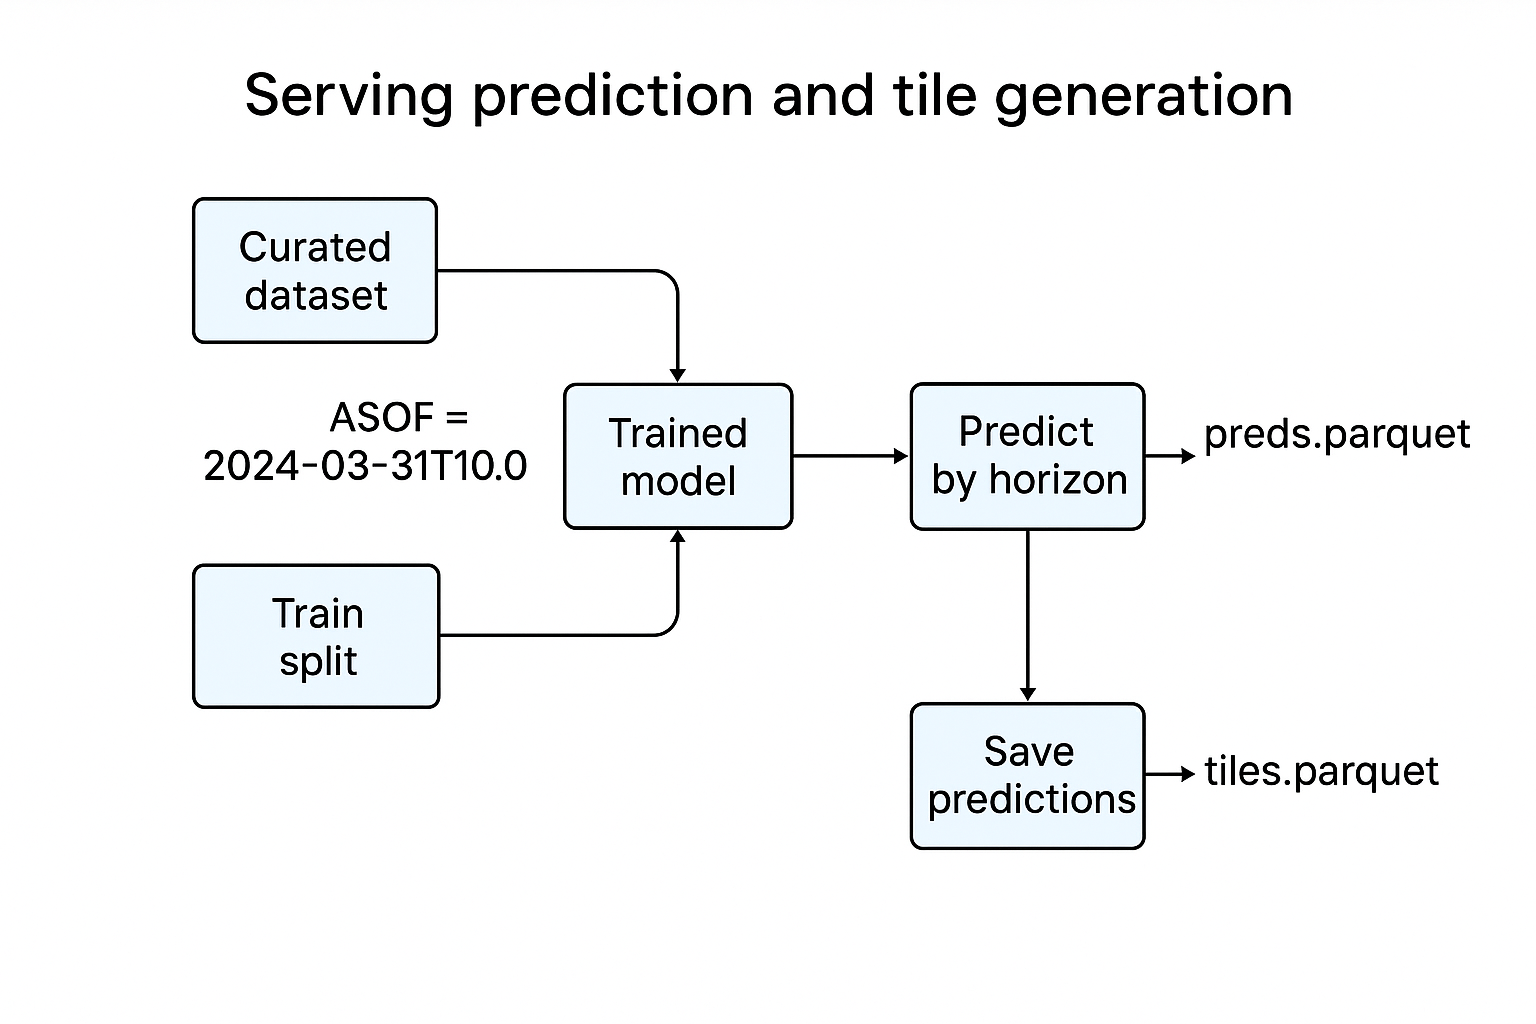

🕓 ASOF → As Of Timestamp

Significa: “a partir de” o “hasta el momento de” la predicción.
Viene del término financiero “as-of date/time”, y en este contexto indica el instante de referencia desde el cual se generan las predicciones futuras.

📘 Ejemplo:

```
ASOF = 2025-03-31 10:00:00
→ el sistema usa los datos disponibles hasta las 10:00 AM del 31 de marzo de 2025 para predecir cuántas bicicletas habrá en cada estación a las 11:00, 12:00, 13:00, etc.
```
En tu pipeline:
- El asof_dt se pasa como parámetro al script predict_batch.py.
- El modelo busca las últimas observaciones previas a ese asof_dt por estación.
- A partir de ellas, proyecta distintos horizontes (h = 1 h, 3 h, 6 h, 12 h).

💡 En otras palabras: es el “corte temporal” que define desde cuándo se generan las predicciones.

⸻

🗺️ Tiles → Map Tiles / Data Tiles

Significa: pequeños archivos (o “baldosas”) con información geográfica y predictiva que el dashboard o el mapa usa para renderizar los datos por zonas o estaciones.

📘 En este proyecto:
- Cada “tile” representa la predicción de disponibilidad de bicis/docks por estación y horizonte.
- Se generan a partir del predictions.parquet (las salidas numéricas del modelo) pero ya formateadas para visualización.

Ejemplo de campos en un tile:

```
station_id	timestamp_pred	h	yhat	lat	lon
102	2025-03-31 11:00	1	8.3	−34.60	−58.42
````

📦 Se guardan típicamente como:
- tiles/tiles_2025-03-31-10h.parquet o
- tiles/tiles_2025-03-31-10h.geojson

Y luego se cargan en el dashboard Streamlit o en un mapa tipo Leaflet.

💡 En otras palabras:
Los tiles son la traducción geográfica de las predicciones para que el mapa pueda mostrar un “semáforo” de disponibilidad.

⸻

🔁 En el flujo:

ASOF timestamp → busca los últimos datos → modelo predice → guarda predictions.parquet → genera tiles.parquet → dashboard los muestra.

### 📘 Glosario técnico — Paso 8 (Serving y generación de Tiles)

| Concepto | Significado | Rol en el flujo | Ejemplo / Archivo |
|-----------|--------------|----------------|--------------------|
| **ASOF** (*As Of Timestamp*) | Instante de referencia a partir del cual se generan las predicciones. Indica hasta qué momento se dispone de datos históricos. | Define el corte temporal: el modelo busca la última observación previa a `ASOF` por estación, y proyecta valores futuros (horizontes 1h, 3h, 6h, 12h…). | `ASOF = 2025-03-31 10:00:00` |
| **Predictions.parquet** | Archivo tabular con las predicciones numéricas para cada estación y horizonte. | Contiene las salidas directas del modelo (`yhat`). | `predictions/preds_2025-03-31-10h.parquet` |
| **Tiles** (*Map Tiles / Data Tiles*) | Formato geográfico que integra las predicciones con coordenadas (lat/lon) para visualización en un mapa o dashboard. | Se usa en el front-end para colorear estaciones según disponibilidad (verde ↔ alta, rojo ↔ baja). | `tiles/tiles_2025-03-31-10h.parquet` o `.geojson` |

🧩 **Resumen visual del flujo**

    ┌────────────────────┐
    │  Curated dataset   │
    └────────┬───────────┘
             │
      (ASOF = corte temporal)
             │
    ┌────────▼──────────┐
    │   Trained model   │
    └────────┬──────────┘
             │
    ┌────────▼──────────┐
    │ Predict by horizon│───▶ predictions.parquet
    └────────┬──────────┘
             │
    ┌────────▼──────────┐
    │ Save predictions  │───▶ tiles.parquet (para mapa)
    └───────────────────┘

💡 *El parámetro `ASOF` asegura consistencia temporal; los `tiles` permiten traducir los resultados del modelo a una representación visual geográfica.*

In [19]:
import pandas as pd
preds = pd.read_parquet("../predictions/latest.parquet")

# 1) ¿Varía algo por horizonte?
preds.groupby("h")["yhat"].describe()

# 2) ¿Para la misma estación/ts base las features usadas son iguales para todos los h?
# (esto explicaría por qué el modelo devuelve lo mismo para 1,3,6,12)
Xref = pd.read_parquet("../data/curated/ecobici_model_ready.parquet")
cols_feats = ["y_lag1","y_lag2","y_ma3","hour","dow","is_weekend","month"]  # ajustá si usás más
Xref[["station_id","ts_local"] + cols_feats].sort_values(["station_id","ts_local"]).tail(3)

,station_id,ts_local,y_lag1,y_lag2,y_ma3,hour,dow,is_weekend,month
198948,593,2025-10-06 21:07:03-03:00,9.0,9.0,9.0,21,0,0,10
198949,593,2025-10-06 21:10:04-03:00,9.0,9.0,9.0,21,0,0,10
198950,593,2025-10-06 21:13:05-03:00,9.0,9.0,9.0,21,0,0,10


In [21]:
from pycaret.regression import load_model, predict_model
import pandas as pd

model = load_model("../models/03A_pycaret/pycaret_best_model")  # sin .pkl
X_base = pd.read_parquet("../data/curated/ecobici_model_ready.parquet")

def build_future(X, h):
    X = X.copy()
    X["timestamp_pred"] = X["ts_local"] + pd.to_timedelta(h, "h")
    X["hour"] = (X["hour"] + h) % 24
    # si tu dataset ya trae dow/month de la hora actual, recomputalos para T+h:
    X["dow"] = (X["timestamp_pred"].dt.dayofweek).astype(int)
    X["month"] = (X["timestamp_pred"].dt.month).astype(int)
    X["is_weekend"] = X["dow"].isin([5,6]).astype(int)
    X["hour_sin"] = np.sin(2*np.pi*X["hour"]/24.0)
    X["hour_cos"] = np.cos(2*np.pi*X["hour"]/24.0)
    return X

dfs = []
for h in [1,3,6,12]:
    X_h = build_future(X_base, h)
    out = predict_model(model, data=X_h)
    dfs.append(out[["station_id","timestamp_pred"]].assign(h=h, yhat=out["Label"]))

preds = pd.concat(dfs, ignore_index=True)
preds.to_parquet("../predictions/latest.parquet", index=False)

Transformation Pipeline and Model Successfully Loaded


KeyError: "['num_bikes_available_types_mechanical', 'num_bikes_available_types_ebike'] not in index"

In [24]:
import pandas as pd
df = pd.read_parquet("../data/splits/train.parquet")
cols = ["hour","dow","month","is_weekend","y_lag1","y_lag2","y_ma3"]
for c in cols:
    if c in df.columns:
        print(f"{c:>12}: {df[c].nunique()} valores únicos")

        hour: 15 valores únicos
         dow: 2 valores únicos
       month: 1 valores únicos
  is_weekend: 2 valores únicos
      y_lag1: 30 valores únicos
      y_lag2: 30 valores únicos
       y_ma3: 86 valores únicos
